### Importing necessary libraries


In [11]:
import tensorflow as tf
from google.colab import drive
import zipfile
from tensorflow.compat.v1 import ConfigProto , InteractiveSession
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np

In [2]:
# Code to control the GPU usage
config = ConfigProto ( )
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.allow_growth = True 
session = InteractiveSession ( config = config )

### Checking for CPU/GPU

In [3]:
devices = [ "CPU" , "GPU" ]
for device in devices:
  out = tf.config.list_physical_devices ( )
  if len ( out ) > 0:
    print ( device , "is available." )
  else:
    print ( device , "is not available." )

CPU is available.
GPU is available.


### Checking the GPU configuration

In [4]:
!nvidia-smi

Fri Jan 29 16:38:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    32W /  70W |    227MiB / 15079MiB |      2%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Reading the dataset after extraction from Google drive

In [5]:
drive.mount ('/content/drive' ) 
zip_ref = zipfile.ZipFile ( "/content/drive/My Drive/dogs-vs-cats.zip", 'r' )
zip_ref.extractall ( "/content" )
zip_ref.close ( )

Mounted at /content/drive


In [6]:
for files in os.listdir ( "/content" ):
  if files == "test1.zip" or files == "train.zip":
    zip_ref = zipfile.ZipFile ( files , 'r' )
    zip_ref.extractall ( "/content" )
    zip_ref.close ( )

### Since the files in training folder are unorganized, we'll have to label them

In [21]:
filenames = os.listdir ( "/content/train" )
category = [ ]
for files in filenames:
  if files.split ( "." ) [ 0 ] == "dog":
    category.append ( "Dog" )
  else:
    category.append ( "Cat" )
df = pd.DataFrame ( { "Filename" : filenames , "Category" : category } )
df.sample ( 5 )

,Filename,Category
17861,cat.3496.jpg,Cat
23569,dog.1152.jpg,Dog
2678,cat.1906.jpg,Cat
7955,dog.9833.jpg,Dog
1736,cat.2922.jpg,Cat


### Splitting into train and test data

In [24]:
train_df , test_df = df [ : 20000 ] , df [ 20000 : ]

### Preprocessing the Train data

In [31]:
train_data = ImageDataGenerator ( rescale = 1. / 255 ,  
                                 shear_range = 0.2 , 
                                 zoom_range = 0.2 , 
                                 horizontal_flip = True )

In [32]:
training_set = train_data.flow_from_dataframe ( train_df , "/content/train" , 
                                               x_col = "Filename" , y_col = "Category" ,
                                               target_size = ( 64 , 64 ) , 
                                               batch_size = 32 , 
                                               class_mode = "binary" )

Found 20000 validated image filenames belonging to 2 classes.


### Preprocessing the Test data

In [33]:
test_data = ImageDataGenerator ( rescale = 1. / 255 )

In [34]:
test_set = train_data.flow_from_dataframe ( test_df , "/content/train" , 
                                               x_col = "Filename" , y_col = "Category" ,
                                               target_size = ( 64 , 64 ) , 
                                               batch_size = 32 , 
                                               class_mode = "binary" )

Found 5000 validated image filenames belonging to 2 classes.


### Model building

In [29]:
cnn = tf.keras.models.Sequential ( )
# Convolution Layer
cnn.add ( tf.keras.layers.Conv2D ( 32 , kernel_size = 3 , padding = "same" , activation = "relu" , input_shape = [ 64 , 64 , 3 ] ) )
# Pooling Layer
cnn.add ( tf.keras.layers.MaxPool2D ( pool_size = 2 , strides = 2 ) )
# Adding one more layer
cnn.add ( tf.keras.layers.Conv2D ( 32 , kernel_size = 3 , padding = "same" , activation = "relu" , input_shape = [ 64 , 64 , 3 ] ) )
cnn.add ( tf.keras.layers.MaxPool2D ( pool_size = ( 2 , 2 ) , strides = 2 ) )
# Flattening layer
cnn.add ( tf.keras.layers.Flatten ( ) )
# Adding a full connected dense layer
cnn.add ( tf.keras.layers.Dense ( 128 , activation = "relu" ) )
# Adding an output layer
cnn.add ( tf.keras.layers.Dense ( 1 , activation = "sigmoid" ) )

In [30]:
cnn.summary ( )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [35]:
cnn.compile ( optimizer = "adam" , metrics = [ "accuracy" ] , loss = "binary_crossentropy" )
cnn.fit ( training_set , validation_data = test_set , epochs = 10 )

Epoch 1/10
625/625 [==============================] - 87s 128ms/step - loss: 0.6787 - accuracy: 0.5799 - val_loss: 0.5890 - val_accuracy: 0.6846
Epoch 2/10
625/625 [==============================] - 78s 125ms/step - loss: 0.5687 - accuracy: 0.7054 - val_loss: 0.5443 - val_accuracy: 0.7190
Epoch 3/10
625/625 [==============================] - 79s 126ms/step - loss: 0.5166 - accuracy: 0.7402 - val_loss: 0.4989 - val_accuracy: 0.7570
Epoch 4/10
625/625 [==============================] - 78s 126ms/step - loss: 0.4849 - accuracy: 0.7663 - val_loss: 0.4992 - val_accuracy: 0.7594
Epoch 5/10
625/625 [==============================] - 80s 128ms/step - loss: 0.4587 - accuracy: 0.7834 - val_loss: 0.4846 - val_accuracy: 0.7696
Epoch 6/10
625/625 [==============================] - 79s 126ms/step - loss: 0.4507 - accuracy: 0.7846 - val_loss: 0.4593 - val_accuracy: 0.7848
Epoch 7/10
625/625 [==============================] - 78s 125ms/step - loss: 0.4357 - accuracy: 0.7964 - val_loss: 0.4500 - val_ac

### Saving the Model

In [36]:
cnn.save ( "DogsVsCats.h5" )

### Testing new data

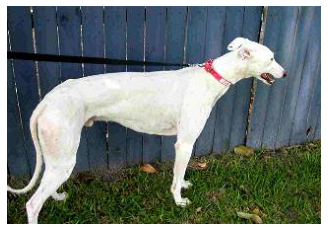

[[0.99995756]] Dog


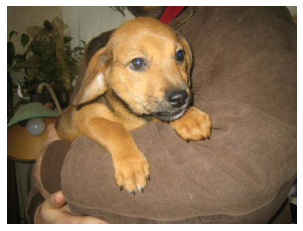

[[0.89949495]] Dog


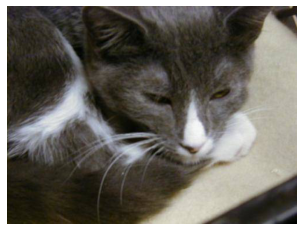

[[0.03223746]] Cat


In [79]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
name = [ "69.jpg" , "420.jpg" , "2611.jpg" ]
for file_img in name:
  img = mpimg.imread ( "/content/test1/" + file_img )
  img = plt.imshow ( img )
  plt.axis ( "off" )
  plt.show ( )
  img = image.load_img ( "/content/test1/" + file_img , target_size = ( 64 , 64 , 3 ) )
  images = image.img_to_array ( img )
  images = images / 255 
  images = np.expand_dims ( images , axis = 0 )
  r = cnn.predict ( images )
  if r [ 0 ] [ 0 ] > 0.5:
    print ( r , "Dog" )
  else:
    print ( r , "Cat" )